# Predicting the Modifier Susceptibility

This notebook outlines the steps taken to predict the `is_modifier` column from a given dataset.

## Import Libraries

In [2]:
%reload_kedro

[10/16/23 17:57:20] INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=844893;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=771751;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[10/16/23 17:57:26] INFO     Kedro project ModSpy-Data                                              ]8;id=457757;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=790685;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=670691;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=966604;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt

## Data Preprocessing

In [4]:
# Load the dataset and drop columns with missing values
dataset = catalog.load("modifiers")
dataset_clean = dataset.dropna(axis=1)

# Split the data into features and target
X = dataset_clean.drop(['is_modifier'], axis=1)
y = dataset_clean['is_modifier']

# Select only numerical features
X_numeric = X.select_dtypes(include=['float64'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42, stratify=y)

[10/16/23 17:57:28] INFO     Loading data from 'modifiers' (CSVDataSet)...                      ]8;id=535737;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=773718;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

## Feature Selection

In [5]:
# Initialize a random forest classifier and fit it to the training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Use SelectFromModel for feature selection
sfm = SelectFromModel(rf_classifier, threshold='mean')
sfm.fit(X_train, y_train)

# Select the important features
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

## Model Building and Evaluation

In [6]:
# Train a new random forest classifier on the important features
rf_classifier_important = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier_important.fit(X_important_train, y_train)

# Predict the target for the test set
y_pred = rf_classifier_important.predict(X_important_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
accuracy, classification_rep

(0.9872854418308964,
 '              precision    recall  f1-score   support\n\n         0.0       0.99      1.00      0.99      1464\n         1.0       0.96      0.85      0.90       109\n\n    accuracy                           0.99      1573\n   macro avg       0.97      0.93      0.95      1573\nweighted avg       0.99      0.99      0.99      1573\n')

## PR Curve

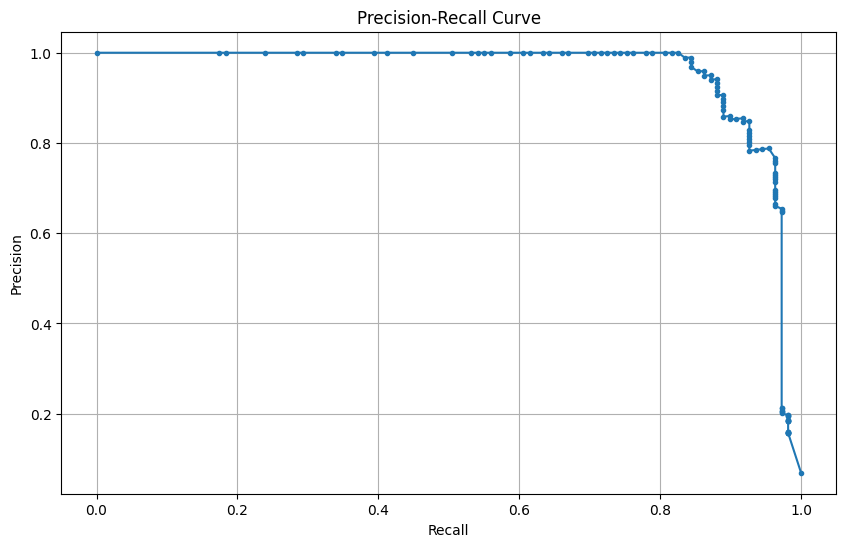

In [7]:
# Compute precision-recall pairs for different probability thresholds
y_scores = rf_classifier_important.predict_proba(X_important_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()
